<a href="https://colab.research.google.com/github/Paulnewbee/GreatLearner/blob/Demo/Load_Forecast_Hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt

In [10]:
# 2. Generate synthetic daily load data
# For live demo purposes, we simulate daily load patterns using sine waves and noise
np.random.seed(42)  # For reproducibility
days = pd.date_range('2023-01-01', periods=365, freq='D')  # Generate 1 year of daily data

# Simulate electricity load with seasonality and random noise
load = 1000 + 100*np.sin(2 * np.pi * days.dayofyear / 365) + 50*np.random.randn(365)

# Simulate daily temperature (also seasonal with noise)
weather_temp = 60 + 20*np.sin(2 * np.pi * days.dayofyear / 365 + np.pi/4) + 10*np.random.randn(365)

# Create a DataFrame
df = pd.DataFrame({
    'date': days,
    'dayofweek': days.dayofweek,    # Monday=0, Sunday=6
    'month': days.month,            # Month of the year
    'temperature': weather_temp,    # Daily average temperature
    'load': load                    # Simulated electricity load
})

df.head()

,date,dayofweek,month,temperature,load
0,2023-01-01,6,1,70.371269,1026.557043
1,2023-01-02,0,1,76.861475,996.528946
2,2023-01-03,1,1,74.979218,1037.546394
3,2023-01-04,2,1,76.058397,1083.031736
4,2023-01-05,3,1,67.575412,996.888811


In [11]:
# 3. Define features (X) and target variable (y)
X = df[['dayofweek', 'month', 'temperature']]  # Features: simple calendar + weather info
y = df['load']                                 # Target: load we want to predict

In [12]:
# 4. Split data into training and testing sets
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((292, 3), (73, 3))

In [14]:
# 5. Create LightGBM datasets
# LightGBM uses its own Dataset structure for faster processing
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [23]:
# 6. Define model parameters
params = {
    'objective': 'regression',    # Regression task (not classification)
    'metric': 'rmse',             # Root Mean Squared Error (RMSE) for evaluation
    'boosting_type': 'dart',      # Gradient Boosting Decision Tree with dropout (not too rely on specific feature)
    'learning_rate': 0.1,         # Step size shrinkage (controls how much each tree affects model)
    'num_leaves': 40,             # Max number of leaves in one tree (controls complexity)
    'verbose': -1                 # Suppress warnings
}

In [26]:
# 7. Train the LightGBM model
model = lgb.train(params, train_data, valid_sets=[test_data])

In [27]:
# 8. Predict on the test set
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [28]:
# 9. Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mape_score = mape(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}, Mean Absolute Percentage Error: {mape_score:.2f}")

Mean Squared Error: 12924.73, Mean Absolute Percentage Error: 0.10


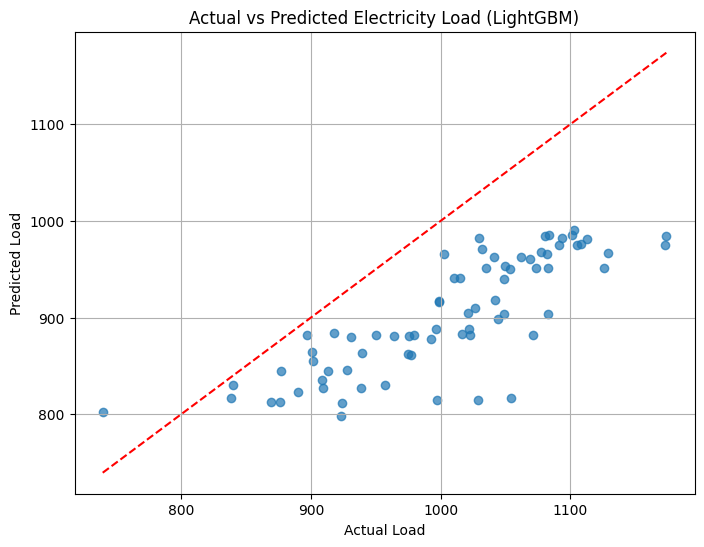

In [29]:
# 10. Plot Actual vs Predicted Load
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Load')
plt.ylabel('Predicted Load')
plt.title('Actual vs Predicted Electricity Load (LightGBM)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.grid()
plt.show()

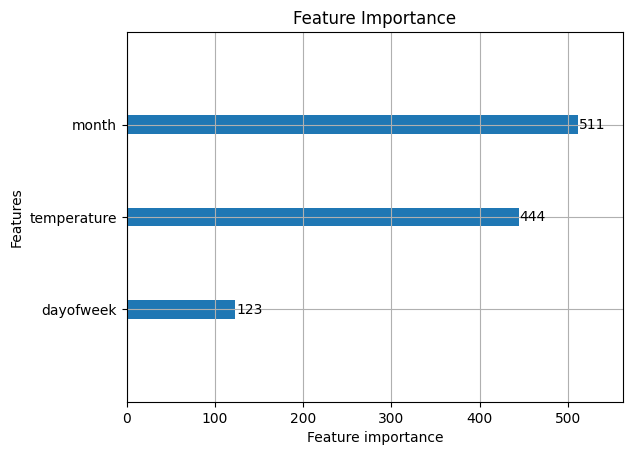

In [30]:
# 11. Optional: Plot feature importance
lgb.plot_importance(model, max_num_features=10)
plt.title('Feature Importance')
plt.show()